In [51]:
import pyspark as pys
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [52]:
sp = SparkSession.builder.appName("SalesAnalysis").getOrCreate()

In [53]:
df = sp.read.csv("sales.csv", header=True, inferSchema=True)

In [54]:
df.show()

+-----------+-----------+------------+---------+--------+--------+--------------------+--------------+----------+-----------+----------------+----------------+------------+
|   Retailer|Retailer ID|Invoice Date|   Region|   State|    City|             Product|Price per Unit|Units Sold|Total Sales|Operating Profit|Operating Margin|Sales Method|
+-----------+-----------+------------+---------+--------+--------+--------------------+--------------+----------+-----------+----------------+----------------+------------+
|Foot Locker|    1185732|  01/01/2020|Northeast|New York|New York|Men's Street Foot...|          50.0|     1,200|   600,000 |        300,000 |             50%|    In-store|
|Foot Locker|    1185732|  02/01/2020|Northeast|New York|New York|Men's Athletic Fo...|          50.0|     1,000|   500,000 |        150,000 |             30%|    In-store|
|Foot Locker|    1185732|  03/01/2020|Northeast|New York|New York|Women's Street Fo...|          40.0|     1,000|   400,000 |        14

In [55]:
from pyspark.sql.functions import regexp_replace, col
from pyspark.sql.functions import to_date

df = df.withColumn("Total Sales", regexp_replace(col("Total Sales"), ",", ""))
df = df.withColumn("Operating Profit", regexp_replace(col("Operating Profit"), ",", ""))
df = df.withColumn("Units Sold", regexp_replace(col("Units Sold"), ",", ""))
df = df.withColumn("Total Sales", col("Total Sales").cast("double"))
df = df.withColumn("Operating Profit", col("Operating Profit").cast("double"))
df = df.withColumn("Invoice Date", to_date(col("Invoice Date"), "dd/MM/yyyy"))

In [56]:
df = df.withColumnRenamed('Total Sales', 'Total_Sales')
df = df.withColumnRenamed('Operating Profit', 'Operating_Profit')
df = df.withColumnRenamed('Price per Unit', 'Price_per_Unit')
df = df.withColumnRenamed('Units Sold', 'Unit_Sold')
df = df.withColumnRenamed('Invoice Date', 'Invoice_DATE')
df = df.withColumnRenamed('Sales Method', 'Sales_Method')


In [57]:
df.createOrReplaceTempView("sales_analysis")

In [58]:
sp.sql("SELECT * FROM sales_analysis").show()

+-----------+-----------+------------+---------+--------+--------+--------------------+--------------+---------+-----------+----------------+----------------+------------+
|   Retailer|Retailer ID|Invoice_DATE|   Region|   State|    City|             Product|Price_per_Unit|Unit_Sold|Total_Sales|Operating_Profit|Operating Margin|Sales_Method|
+-----------+-----------+------------+---------+--------+--------+--------------------+--------------+---------+-----------+----------------+----------------+------------+
|Foot Locker|    1185732|  2020-01-01|Northeast|New York|New York|Men's Street Foot...|          50.0|     1200|   600000.0|        300000.0|             50%|    In-store|
|Foot Locker|    1185732|  2020-01-02|Northeast|New York|New York|Men's Athletic Fo...|          50.0|     1000|   500000.0|        150000.0|             30%|    In-store|
|Foot Locker|    1185732|  2020-01-03|Northeast|New York|New York|Women's Street Fo...|          40.0|     1000|   400000.0|        140000.0

In [59]:
res = sp.sql("SELECT SUM(Total_Sales) AS Total_Sales,SUM(operating_profit) AS total_profit,ROUND(AVG(price_per_unit),2) AS avg_price_per_unit,SUM(Unit_Sold) AS units_sold FROM sales_analysis")
res.show()


+------------+------------+------------------+----------+
| Total_Sales|total_profit|avg_price_per_unit|units_sold|
+------------+------------+------------------+----------+
|8.99902125E8|3.32135122E8|             45.22| 2478861.0|
+------------+------------+------------------+----------+



In [60]:
total = res.collect()[0]['Total_Sales']
print(int(total))

899902125


In [61]:
pandas_df = res.toPandas()

In [62]:
total_sales = pandas_df['Total_Sales'][0]
total_profit = pandas_df['total_profit'][0]
avg_price = pandas_df['avg_price_per_unit'][0]
units_sold = pandas_df['units_sold'][0]

In [63]:
sns.set_style("whitegrid")

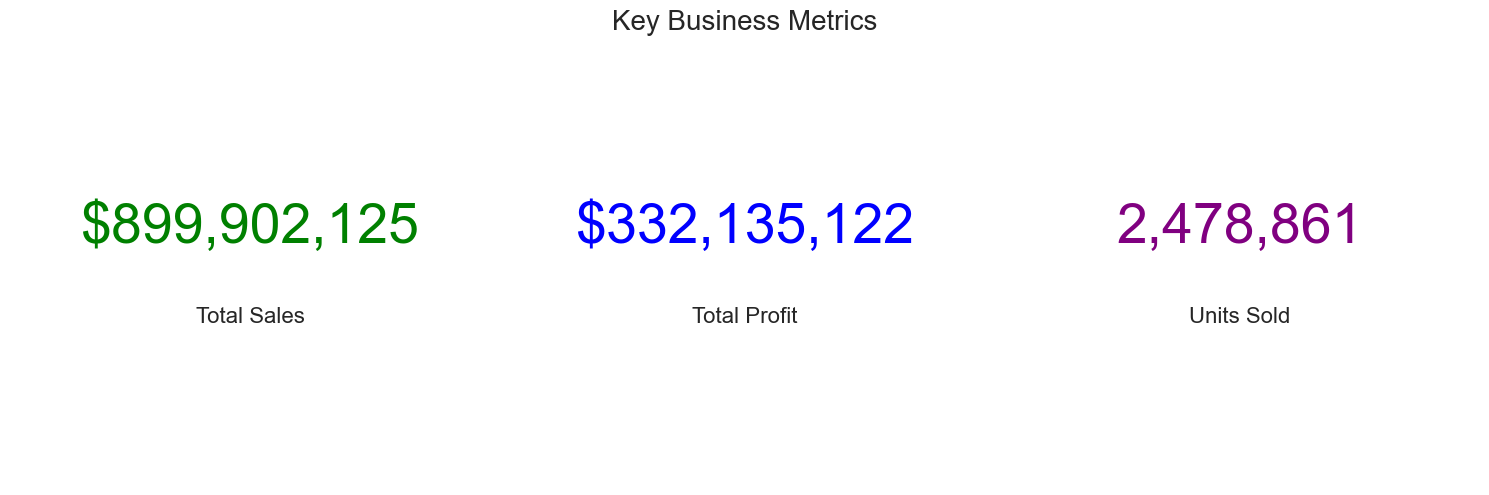

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Key Business Metrics', fontsize=20)

axes[0].text(0.5, 0.6, f'${total_sales:,.0f}', fontsize=40, ha='center', color='green')
axes[0].text(0.5, 0.4, 'Total Sales', fontsize=16, ha='center')
axes[0].axis('off') 

axes[1].text(0.5, 0.6, f'${total_profit:,.0f}', fontsize=40, ha='center', color='blue')
axes[1].text(0.5, 0.4, 'Total Profit', fontsize=16, ha='center')
axes[1].axis('off')

axes[2].text(0.5, 0.6, f'{units_sold:,.0f}', fontsize=40, ha='center', color='purple')
axes[2].text(0.5, 0.4, 'Units Sold', fontsize=16, ha='center')
axes[2].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

In [65]:
sp.sql("SELECT * FROM sales_analysis").show()

+-----------+-----------+------------+---------+--------+--------+--------------------+--------------+---------+-----------+----------------+----------------+------------+
|   Retailer|Retailer ID|Invoice_DATE|   Region|   State|    City|             Product|Price_per_Unit|Unit_Sold|Total_Sales|Operating_Profit|Operating Margin|Sales_Method|
+-----------+-----------+------------+---------+--------+--------+--------------------+--------------+---------+-----------+----------------+----------------+------------+
|Foot Locker|    1185732|  2020-01-01|Northeast|New York|New York|Men's Street Foot...|          50.0|     1200|   600000.0|        300000.0|             50%|    In-store|
|Foot Locker|    1185732|  2020-01-02|Northeast|New York|New York|Men's Athletic Fo...|          50.0|     1000|   500000.0|        150000.0|             30%|    In-store|
|Foot Locker|    1185732|  2020-01-03|Northeast|New York|New York|Women's Street Fo...|          40.0|     1000|   400000.0|        140000.0

In [66]:
res = sp.sql("SELECT MONTH(Invoice_Date)as month, sum(total_sales) FROM sales_analysiS GROUP BY month ")
res.show()

+-----+----------------+
|month|sum(total_sales)|
+-----+----------------+
|   12|     8.5841957E7|
|    1|     7.1479142E7|
|    6|     7.4747372E7|
|    3|     5.6809109E7|
|    5|     8.0507695E7|
|    9|     7.7661459E7|
|    4|      7.233997E7|
|    8|     9.2166201E7|
|    7|     9.5480694E7|
|   10|     6.3911033E7|
|   11|      6.785734E7|
|    2|     6.1100153E7|
+-----+----------------+



In [67]:
pandas_df = res.toPandas()

In [68]:
month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

In [69]:
pandas_df['month_name'] = pandas_df['month'].map(month_map)

In [70]:
print(pandas_df.columns)

Index(['month', 'sum(total_sales)', 'month_name'], dtype='object')


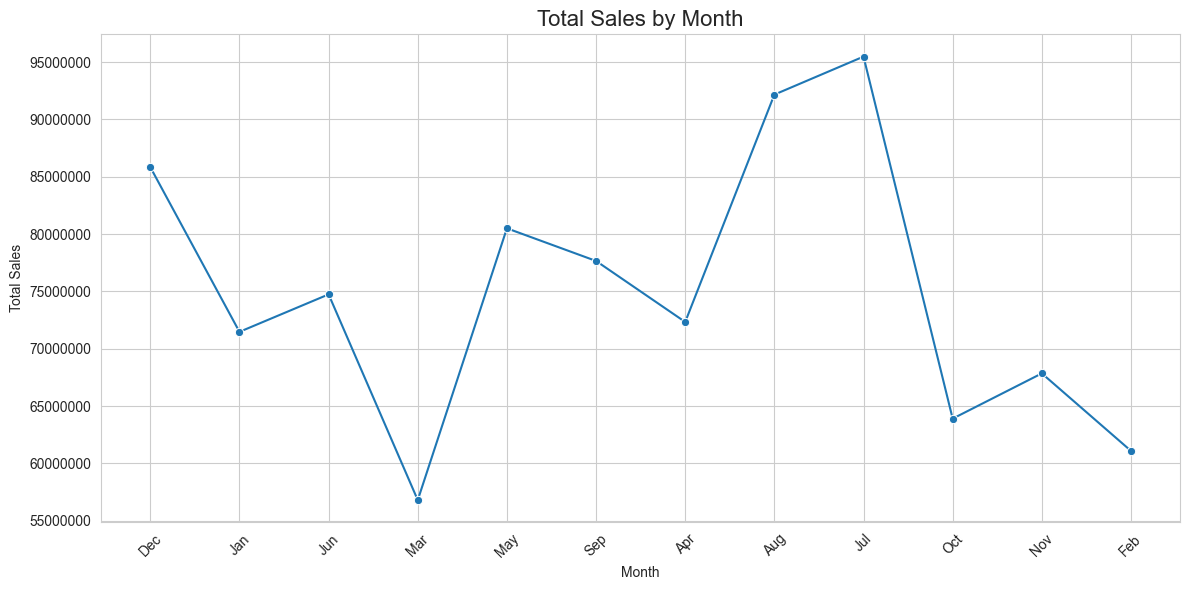

In [71]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='month_name', y='sum(total_sales)', data=pandas_df, marker='o', sort=False)
plt.title('Total Sales by Month', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)

plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout() 
plt.show()

In [72]:
res = sp.sql("SELECT State, sum(total_sales) AS total_sales FROM sales_analysiS GROUP BY state ")
res.show()

+-------------+-----------+
|        State|total_sales|
+-------------+-----------+
|         Utah|  9696420.0|
|       Hawaii|2.2282457E7|
|    Minnesota|  7378068.0|
|         Ohio|1.8484583E7|
|       Oregon|2.1349674E7|
|     Arkansas|1.2639347E7|
|        Texas|4.6359746E7|
| North Dakota|  7735580.0|
| Pennsylvania|1.0357519E7|
|  Connecticut|1.1573448E7|
|     Nebraska|  5929038.0|
|      Vermont|1.4352923E7|
|       Nevada|2.0858509E7|
|   Washington|2.6330718E7|
|     Illinois|  9797488.0|
|     Oklahoma|1.0620734E7|
|     Delaware|1.2298412E7|
|       Alaska|1.4753103E7|
|   New Mexico|1.9865016E7|
|West Virginia| 1.068916E7|
+-------------+-----------+
only showing top 20 rows


In [73]:
pandas_df = res.toPandas()

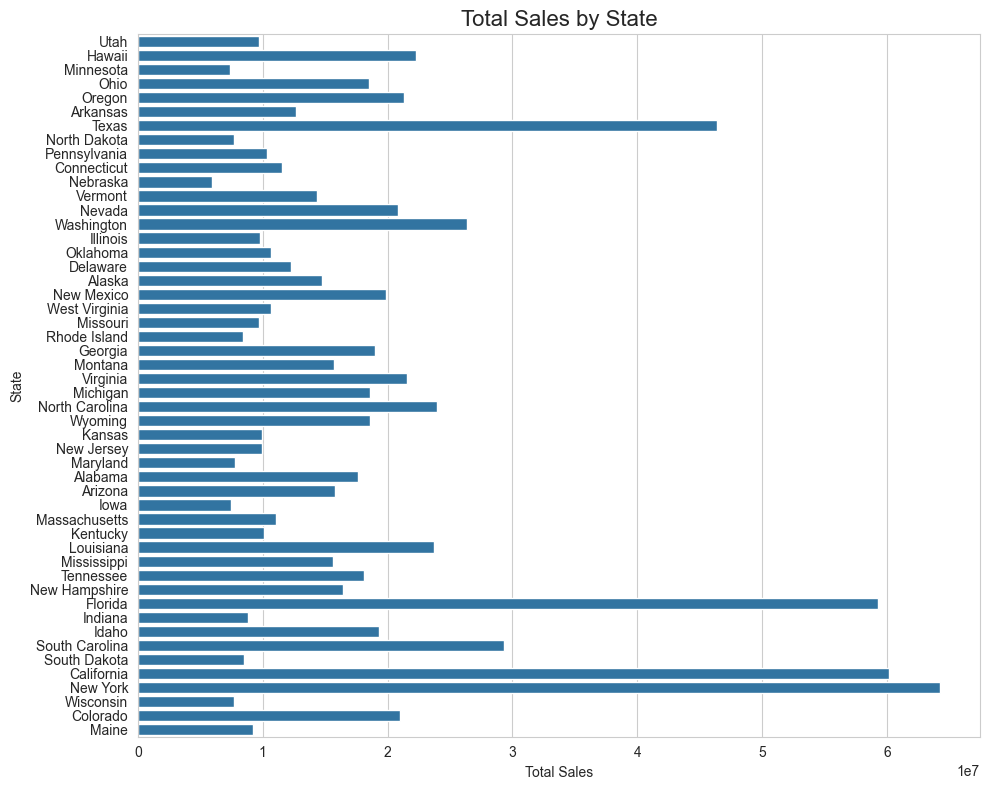

In [74]:
plt.figure(figsize=(10, 8))


sns.barplot(x='total_sales', y='State', data=pandas_df, orient='h')

plt.title('Total Sales by State', fontsize=16)
plt.xlabel('Total Sales')
plt.ylabel('State')

plt.tight_layout()
plt.show()

In [75]:
res = sp.sql("SELECT Region, sum(total_sales) AS total_sales FROM sales_analysiS GROUP BY region ")
res.show()

+---------+------------+
|   Region| total_sales|
+---------+------------+
|  Midwest|1.35800459E8|
|    South|1.44663181E8|
|Southeast|1.63171236E8|
|     West|2.69943182E8|
|Northeast|1.86324067E8|
+---------+------------+



In [76]:
pandas_df = res.toPandas()

In [77]:
explode = [0] * len(pandas_df)  
if not pandas_df.empty:
   
    max_sales_index = pandas_df['total_sales'].idxmax()
    explode[max_sales_index] = 0.1

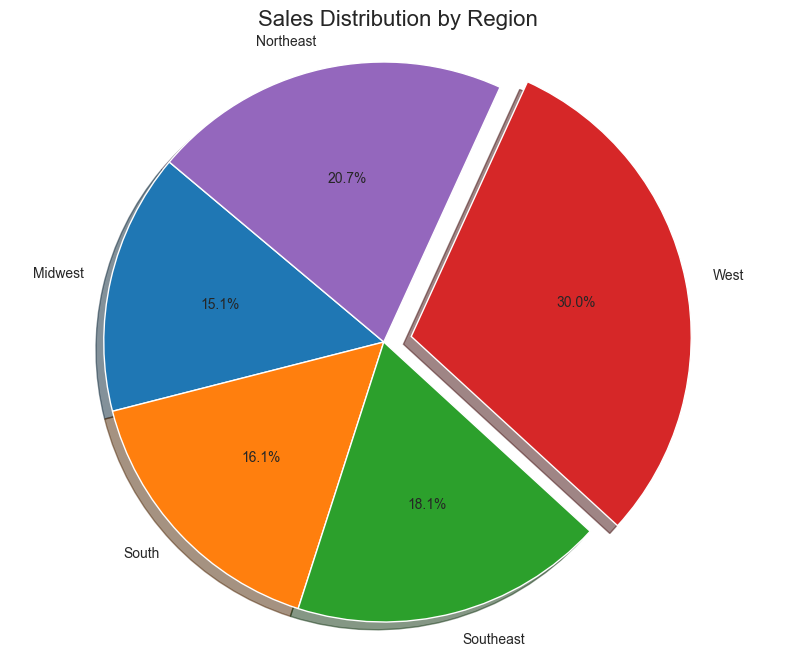

In [78]:
plt.figure(figsize=(10, 8))
plt.pie(
    pandas_df['total_sales'],
    labels=pandas_df['Region'],
    autopct='%1.1f%%', 
    startangle=140,     
    explode=explode,     
    shadow=True          
)

plt.title('Sales Distribution by Region', fontsize=16)
plt.axis('equal')  
plt.show()

In [79]:
res = sp.sql("SELECT * FROM sales_analysis")
res.show()

+-----------+-----------+------------+---------+--------+--------+--------------------+--------------+---------+-----------+----------------+----------------+------------+
|   Retailer|Retailer ID|Invoice_DATE|   Region|   State|    City|             Product|Price_per_Unit|Unit_Sold|Total_Sales|Operating_Profit|Operating Margin|Sales_Method|
+-----------+-----------+------------+---------+--------+--------+--------------------+--------------+---------+-----------+----------------+----------------+------------+
|Foot Locker|    1185732|  2020-01-01|Northeast|New York|New York|Men's Street Foot...|          50.0|     1200|   600000.0|        300000.0|             50%|    In-store|
|Foot Locker|    1185732|  2020-01-02|Northeast|New York|New York|Men's Athletic Fo...|          50.0|     1000|   500000.0|        150000.0|             30%|    In-store|
|Foot Locker|    1185732|  2020-01-03|Northeast|New York|New York|Women's Street Fo...|          40.0|     1000|   400000.0|        140000.0

In [80]:
res = sp.sql("SELECT Product, sum(total_sales) AS total_sales FROM sales_analysiS GROUP BY product ORDER BY total_sales DESC")
res.show()

+--------------------+------------+
|             Product| total_sales|
+--------------------+------------+
|Men's Street Foot...|2.08826244E8|
|     Women's Apparel| 1.7903886E8|
|Men's Athletic Fo...| 1.5367368E8|
|Women's Street Fo...|1.28002813E8|
|       Men's Apparel|1.23728632E8|
|Women's Athletic ...|1.06631896E8|
+--------------------+------------+



In [81]:
pandas_df = res.toPandas()


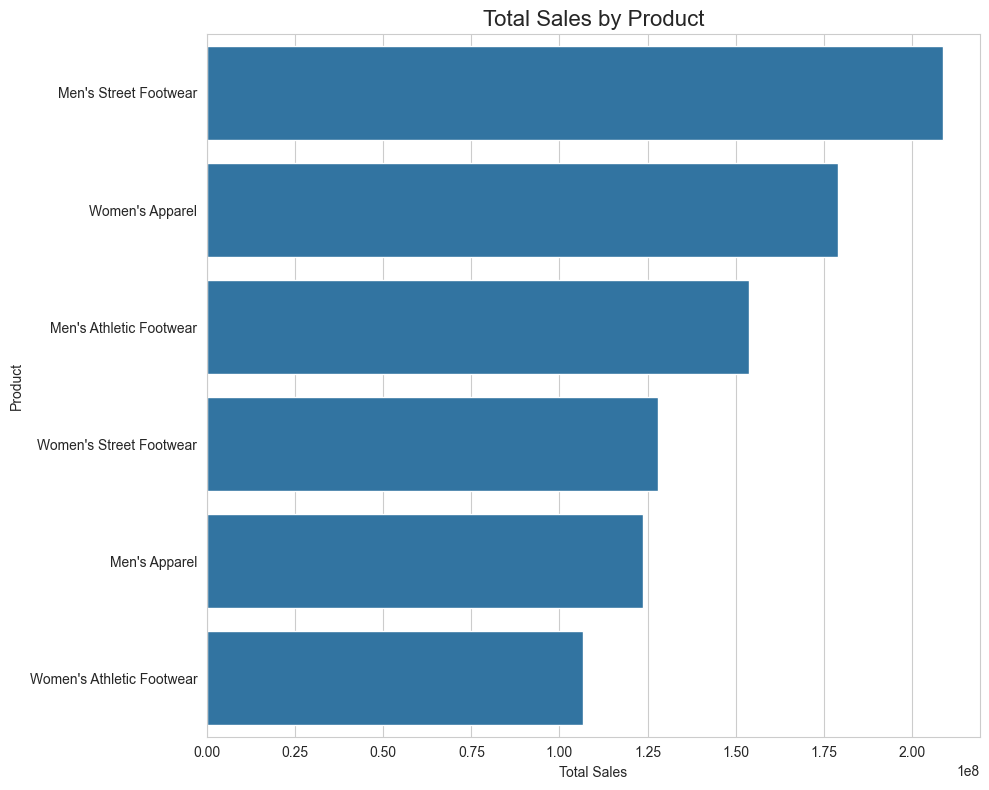

In [82]:
plt.figure(figsize=(10, 8))


sns.barplot(x='total_sales', y='Product', data=pandas_df, orient='h')

plt.title('Total Sales by Product', fontsize=16)
plt.xlabel('Total Sales')
plt.ylabel('Product')


plt.tight_layout()
plt.show()

In [83]:
res = sp.sql("SELECT Retailer, sum(total_sales) AS total_sales FROM sales_analysiS GROUP BY Retailer ORDER BY total_sales DESC")
res.show()

+-------------+------------+
|     Retailer| total_sales|
+-------------+------------+
|    West Gear|2.42964333E8|
|  Foot Locker| 2.2009472E8|
|Sports Direct|1.82470997E8|
|       Kohl's|1.02114753E8|
|       Amazon| 7.7698912E7|
|      Walmart|  7.455841E7|
+-------------+------------+



In [84]:
pandas_df = res.toPandas()

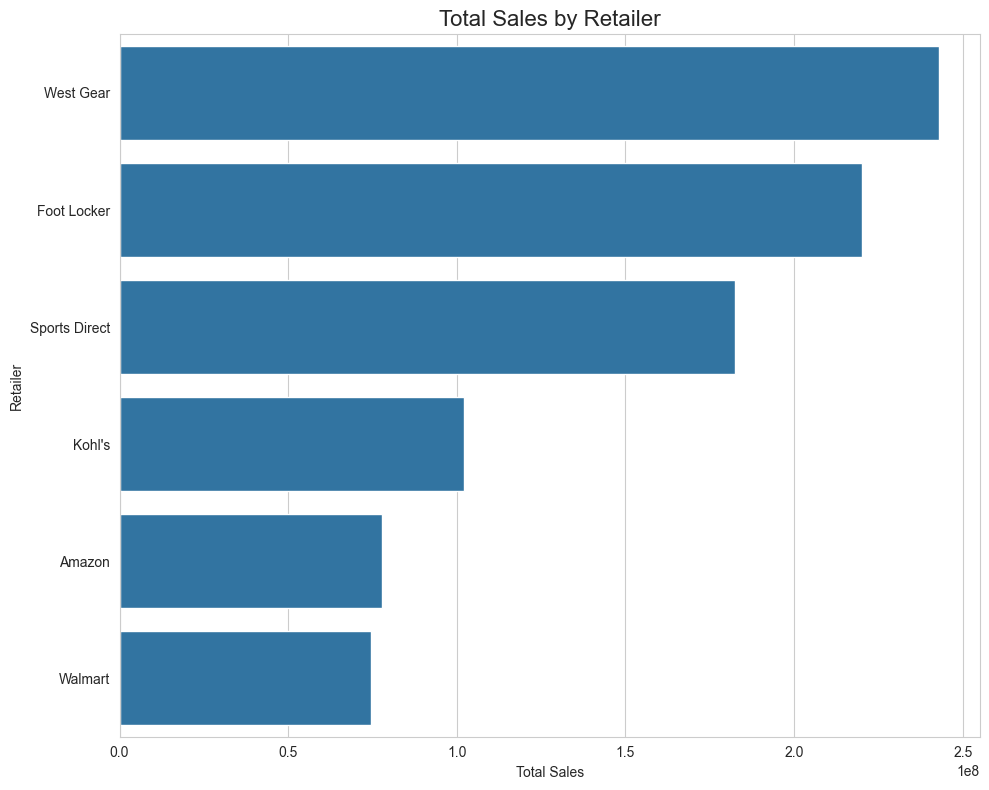

In [85]:
plt.figure(figsize=(10, 8))


sns.barplot(x='total_sales', y='Retailer', data=pandas_df, orient='h')

plt.title('Total Sales by Retailer', fontsize=16)
plt.xlabel('Total Sales')
plt.ylabel('Retailer')


plt.tight_layout()
plt.show()

In [86]:
res = sp.sql("SELECT SPLIT(Product, ' ')[0] AS Gender, SUBSTRING(Product, INSTR(Product, ' ') + 1) AS ProductCategory, SUM(Unit_Sold) AS TotalUnitsSold FROM sales_analysis GROUP BY Gender, ProductCategory ORDER BY Gender, TotalUnitsSold DESC")
res.show()

+-------+-----------------+--------------+
| Gender|  ProductCategory|TotalUnitsSold|
+-------+-----------------+--------------+
|  Men's|  Street Footwear|      593320.0|
|  Men's|Athletic Footwear|      435526.0|
|  Men's|          Apparel|      306683.0|
|Women's|          Apparel|      433827.0|
|Women's|  Street Footwear|      392269.0|
|Women's|Athletic Footwear|      317236.0|
+-------+-----------------+--------------+



In [87]:
pandas_df = res.toPandas()

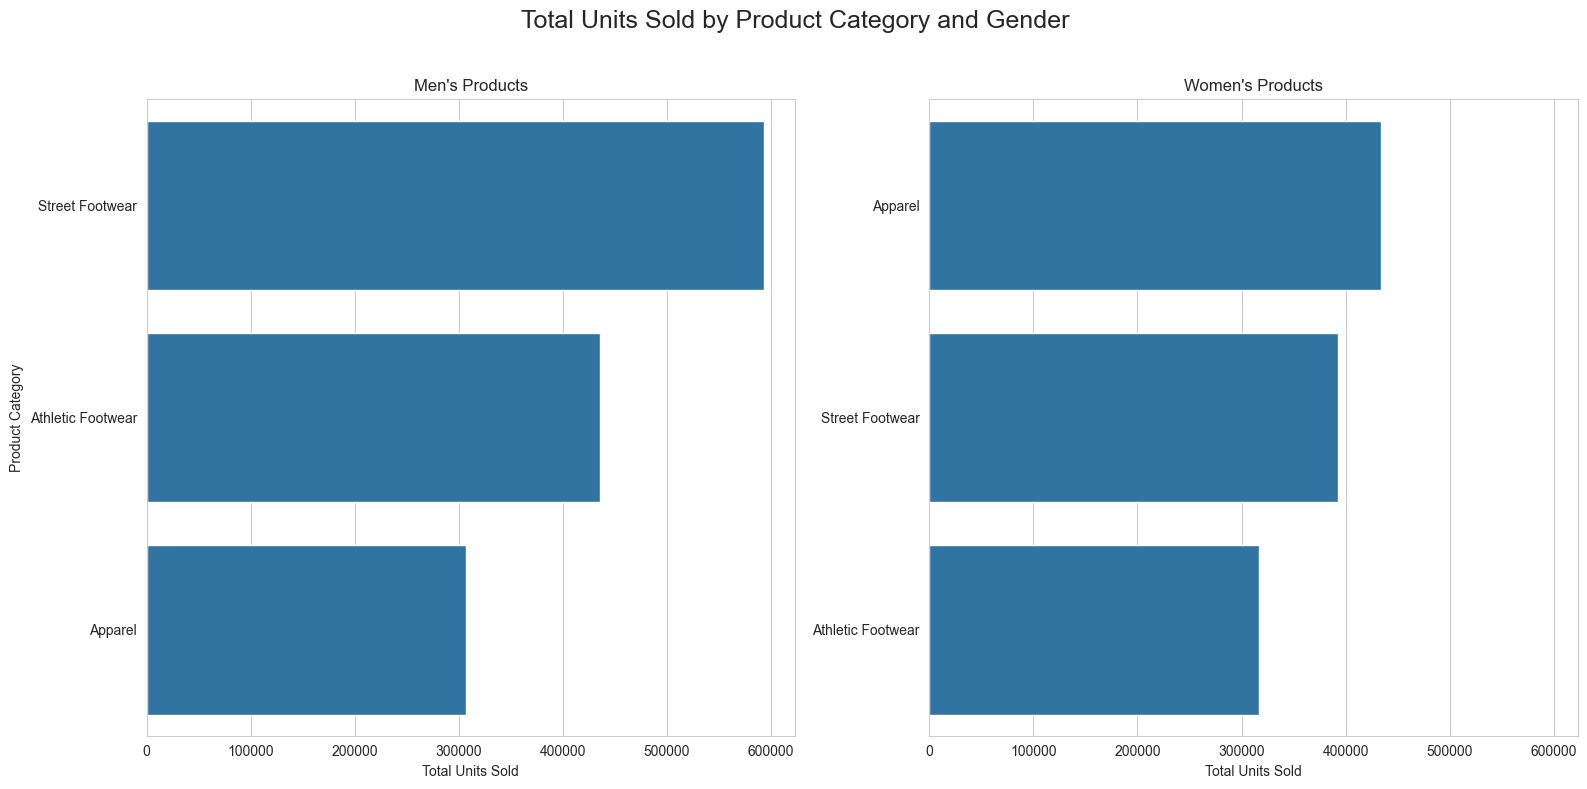

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
fig.suptitle('Total Units Sold by Product Category and Gender', fontsize=18)


mens_data = pandas_df[pandas_df['Gender'] == "Men's"]
womens_data = pandas_df[pandas_df['Gender'] == "Women's"]


sns.barplot(ax=axes[0], x='TotalUnitsSold', y='ProductCategory', data=mens_data, orient='h')
axes[0].set_title("Men's Products")
axes[0].set_xlabel('Total Units Sold')
axes[0].set_ylabel('Product Category')


sns.barplot(ax=axes[1], x='TotalUnitsSold', y='ProductCategory', data=womens_data, orient='h')
axes[1].set_title("Women's Products")
axes[1].set_xlabel('Total Units Sold')
axes[1].set_ylabel('') 


plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

In [89]:
res= sp.sql("SELECT City, sum(operating_profit) AS total_profit FROM sales_analysiS GROUP BY city LIMIT 8")
res.show()

+------------+------------+
|        City|total_profit|
+------------+------------+
|  Charleston| 1.5607205E7|
|     Phoenix|   5344678.0|
|       Omaha|   2439482.0|
|   Anchorage|   4498359.0|
|      Dallas|   8843074.0|
|  Manchester|   5786209.0|
|Philadelphia|   4156749.0|
|  Louisville|   3935833.0|
+------------+------------+



In [90]:
pandas_df = res.toPandas()

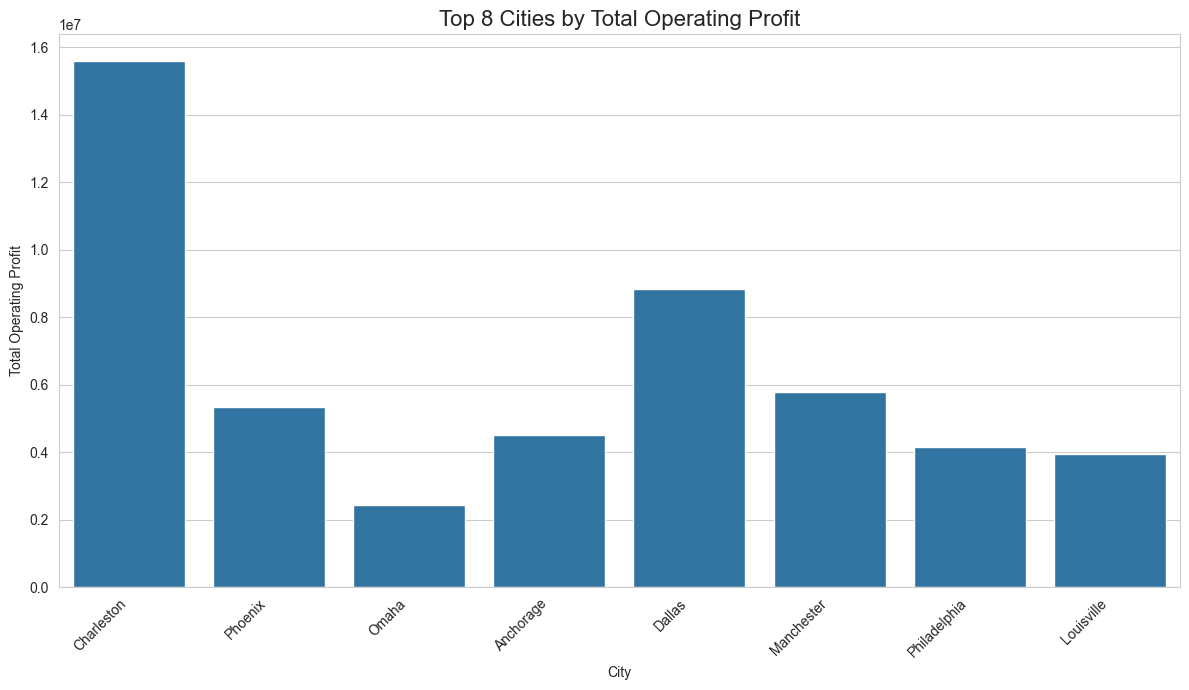

In [91]:
plt.figure(figsize=(12, 7))


sns.barplot(x='City', y='total_profit', data=pandas_df)

plt.title('Top 8 Cities by Total Operating Profit', fontsize=16)
plt.xlabel('City')
plt.ylabel('Total Operating Profit')


plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.show()


In [92]:
res = sp.sql("""
    SELECT 
        Product, 
        SUM(Total_Sales) AS TotalSales, 
        SUM(Operating_Profit) AS TotalProfit, 
        (SUM(Operating_Profit) / SUM(Total_Sales)) * 100 AS ProfitMargin
    FROM sales_analysis
    GROUP BY Product
    ORDER BY ProfitMargin DESC
""")

res.show()


+--------------------+------------+-----------+------------------+
|             Product|  TotalSales|TotalProfit|      ProfitMargin|
+--------------------+------------+-----------+------------------+
|Men's Street Foot...|2.08826244E8|8.2802323E7| 39.65130120331044|
|     Women's Apparel| 1.7903886E8|6.8650996E7|  38.3441874015507|
|Women's Athletic ...|1.06631896E8|3.8975843E7| 36.55176777500046|
|       Men's Apparel|1.23728632E8|4.4763099E7| 36.17844817034751|
|Women's Street Fo...|1.28002813E8|4.5095897E7|35.230395288266045|
|Men's Athletic Fo...| 1.5367368E8|5.1846964E7|33.738349989406125|
+--------------------+------------+-----------+------------------+



In [93]:
pandas_df = res.toPandas()

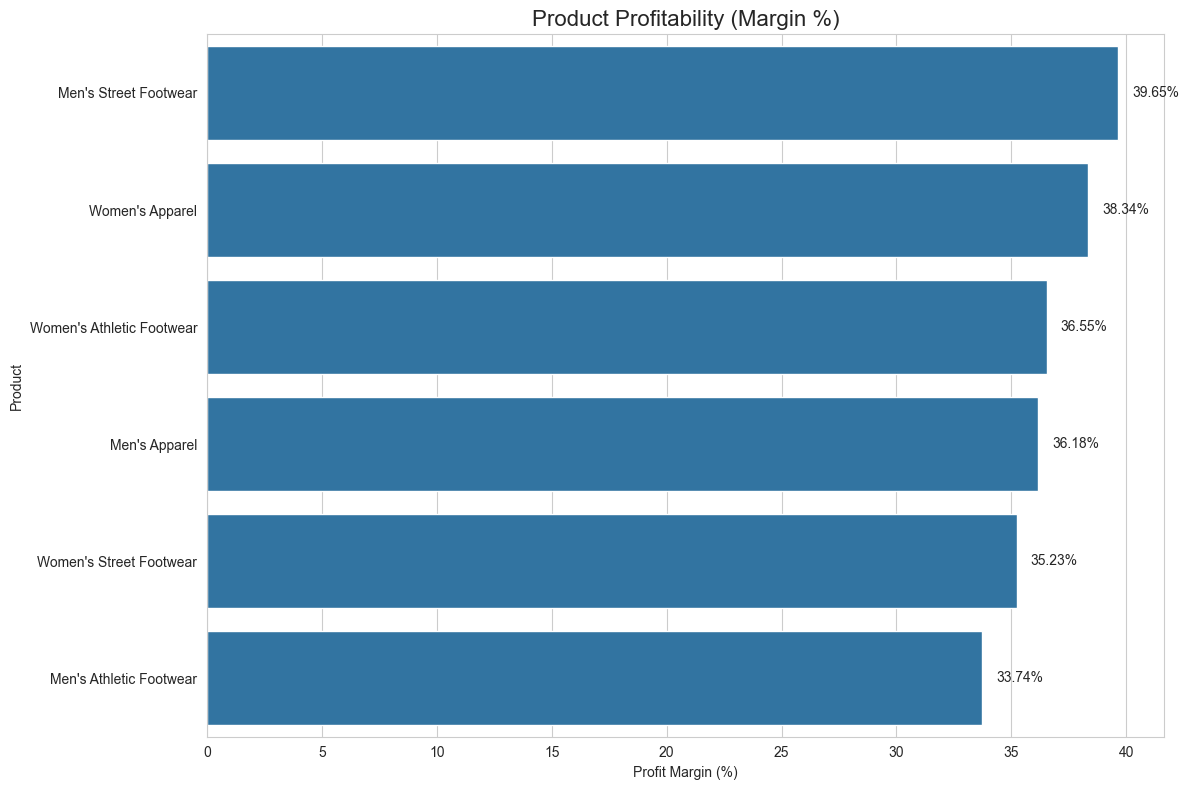

In [ ]:
plt.figure(figsize=(12, 8))

ax = sns.barplot(x='ProfitMargin', y='Product', data=pandas_df, orient='h')

plt.title('Product Profitability (Margin %)', fontsize=16)
plt.xlabel('Profit Margin (%)')
plt.ylabel('Product')


for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.6, p.get_y() + p.get_height() / 2,
             f'{width:.2f}%',
             va='center')

plt.tight_layout()

In [95]:
res = sp.sql("""SELECT
    Sales_Method,
    SUM(Total_Sales) AS TotalSales,
    SUM(Operating_Profit) AS TotalProfit,
    SUM(Unit_Sold) AS TotalUnitsSold
FROM
    sales_analysis
GROUP BY
    Sales_Method
ORDER BY
    TotalSales DESC""")
res.show()

+------------+------------+------------+--------------+
|Sales_Method|  TotalSales| TotalProfit|TotalUnitsSold|
+------------+------------+------------+--------------+
|    In-store| 3.5664375E8|1.27591382E8|      689990.0|
|      Outlet|2.95585493E8|1.07988403E8|      849778.0|
|      Online|2.47672882E8| 9.6555337E7|      939093.0|
+------------+------------+------------+--------------+



In [96]:
pandas_df = res.toPandas()

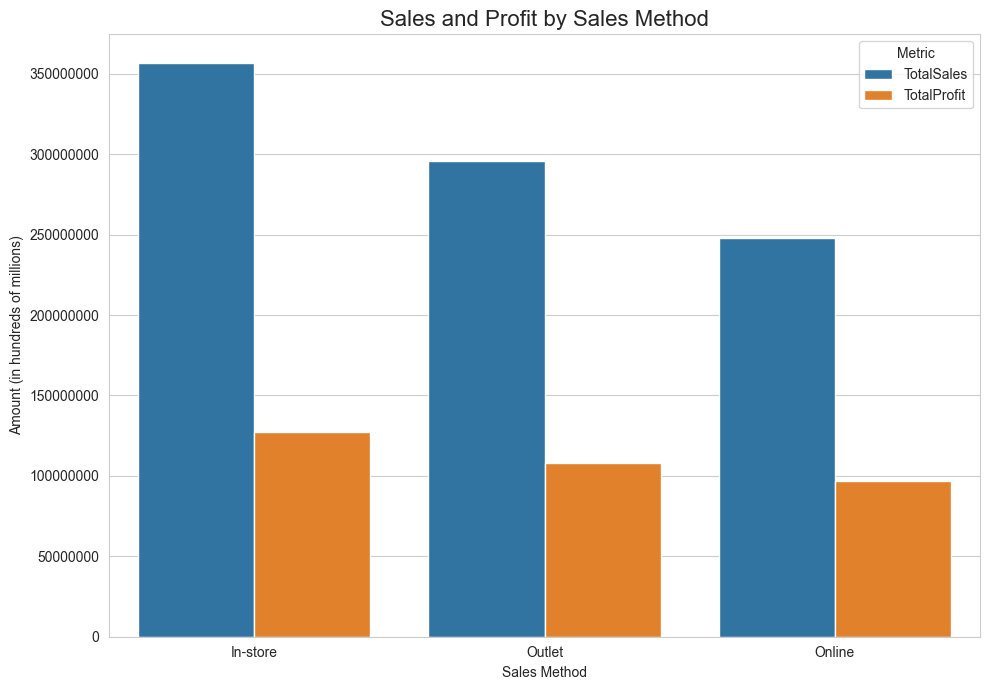

In [ ]:
plot_df = pandas_df.melt(
    id_vars='Sales_Method', 
    value_vars=['TotalSales', 'TotalProfit'], 
    var_name='Metric', 
    value_name='Amount'
)

# Create the plot
plt.figure(figsize=(10, 7))
sns.barplot(x='Sales_Method', y='Amount', hue='Metric', data=plot_df)

plt.title('Sales and Profit by Sales Method', fontsize=16)
plt.xlabel('Sales Method')
plt.ylabel('Amount (in hundreds of millions)')
plt.ticklabel_format(style='plain', axis='y') 
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

In [98]:
res = sp.sql(""" SELECT
    YEAR(Invoice_DATE) AS SalesYear,
    MONTH(Invoice_DATE) AS SalesMonth,
    SUM(Total_Sales) AS MonthlySales
FROM
    sales_analysis
GROUP BY
    SalesYear, SalesMonth
ORDER BY
    SalesYear, SalesMonth""")
res.show()

+---------+----------+------------+
|SalesYear|SalesMonth|MonthlySales|
+---------+----------+------------+
|     2020|         1| 1.6253746E7|
|     2020|         2| 1.4997988E7|
|     2020|         3| 1.7660577E7|
|     2020|         4| 2.4607006E7|
|     2020|         5| 1.6918014E7|
|     2020|         6|   8829819.0|
|     2020|         7| 1.7146013E7|
|     2020|         8|  1.987798E7|
|     2020|         9| 1.8304436E7|
|     2020|        10| 1.0836269E7|
|     2020|        11|   8622300.0|
|     2020|        12|   8026527.0|
|     2021|         1| 5.5225396E7|
|     2021|         2| 4.6102165E7|
|     2021|         3| 3.9148532E7|
|     2021|         4| 4.7732964E7|
|     2021|         5| 6.3589681E7|
|     2021|         6| 6.5917553E7|
|     2021|         7| 7.8334681E7|
|     2021|         8| 7.2288221E7|
+---------+----------+------------+
only showing top 20 rows


In [105]:
pandas_df = res.toPandas()
agg_df = pandas_df.groupby(['SalesMonth', 'SalesYear'], as_index=False)['MonthlySales'].sum()

pivot_df = agg_df.pivot(index='SalesMonth', columns='SalesYear', values='MonthlySales')


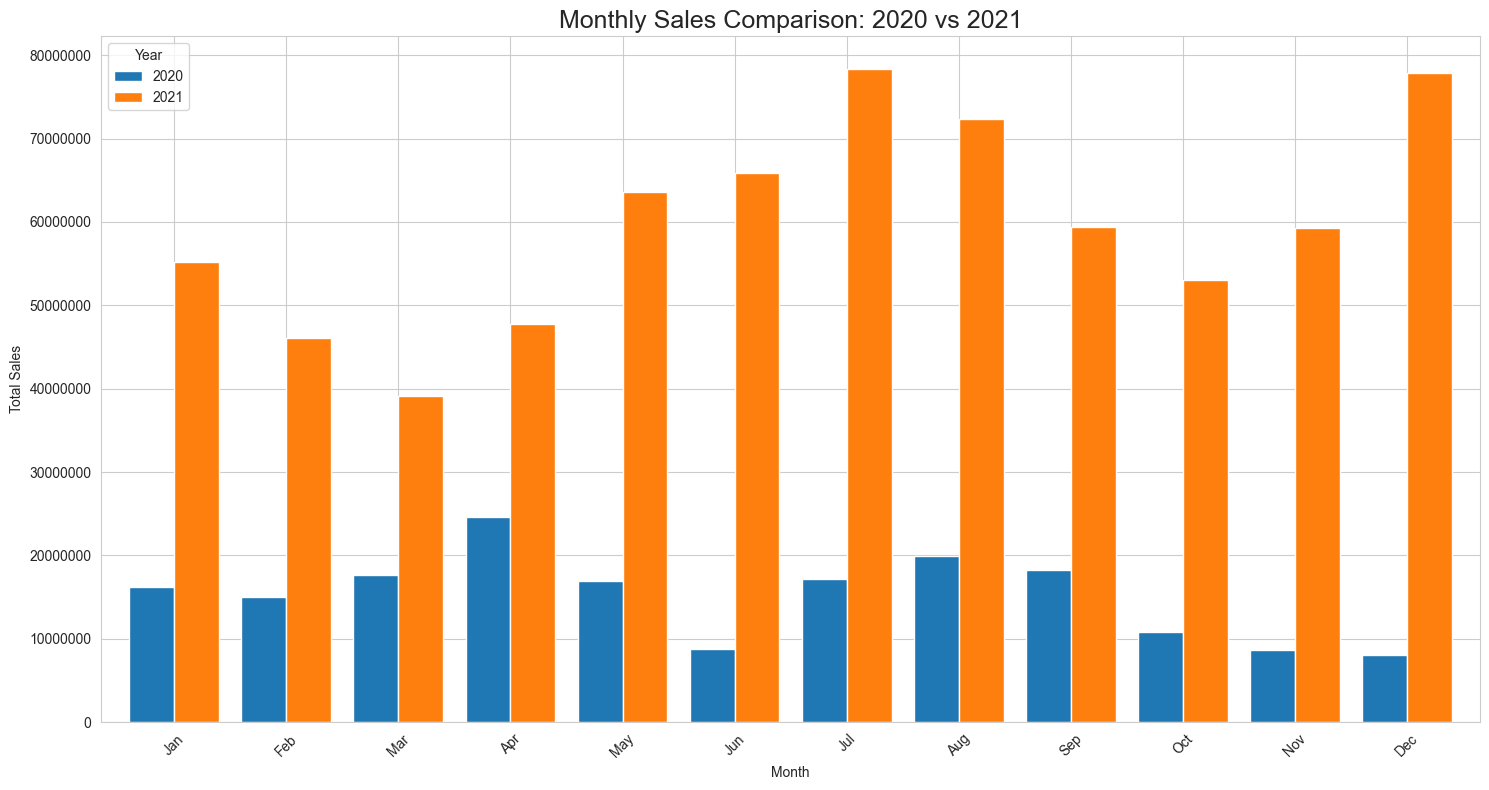

In [106]:
month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
pandas_df['SalesMonth'] = pandas_df['SalesMonth'].map(month_map)


pivot_df = pandas_df.pivot(index='SalesMonth', columns='SalesYear', values='MonthlySales')


month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
pivot_df = pivot_df.reindex(month_order)



pivot_df.plot(kind='bar', figsize=(15, 8), width=0.8)

plt.title('Monthly Sales Comparison: 2020 vs 2021', fontsize=18)
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.legend(title='Year')
plt.tight_layout()
plt.show()